<a href="https://colab.research.google.com/github/mvince33/Coding-Dojo/blob/main/week11/neural_network_kaggle_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Kaggle Exercise
- Michael Vincent
- 8/28

## Imports

In [175]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

# Sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Helper function

In [176]:
# Helper function from the Coding Dojo learning platform to help visualize the 
# metrics of our models
# Learning history plotting function
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

## Load the data

In [177]:
# Load the data

# Note that this data comes from a Kaggle competition. We will be performoing
# a validation split on the train.csv file, and make final predictions for
# the competition useng the teste.csv file.
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQdDRUum294FpjaKz_oYlB-mnC1Pu3EE6hB7EbsQmPgQdhJyi16ZbBAwIHcQov8I5MQHOIhXRo7xkl2/pub?output=csv'
df = pd.read_csv(url, index_col = 'Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Clean the data

In [178]:
# Check for duplicates and missing values
print('Duplicates:', df.duplicated().sum())
print('Missing Values:', df.isna().sum().sum())

Duplicates: 0
Missing Values: 6965


In [179]:
# Drop the columns that are missing less than 5% of their values
filter = (df.isna().sum() / df.shape[0] < 0.05) & (df.isna().sum() > 0)
cols = df.loc[:, filter].columns
df.drop(columns = cols, inplace = True)

In [180]:
# Examine the reamining features with missing data
filter = df.isna().sum() > 0
df.loc[:, filter].info()
print()
df.loc[:, filter].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   FireplaceQu   770 non-null    object 
 3   GarageType    1379 non-null   object 
 4   GarageYrBlt   1379 non-null   float64
 5   GarageFinish  1379 non-null   object 
 6   GarageQual    1379 non-null   object 
 7   GarageCond    1379 non-null   object 
 8   PoolQC        7 non-null      object 
 9   Fence         281 non-null    object 
 10  MiscFeature   54 non-null     object 
dtypes: float64(2), object(9)
memory usage: 136.9+ KB



,LotFrontage,GarageYrBlt
count,1201.000000,1379.000000
mean,70.049958,1978.506164
std,24.284752,24.689725
min,21.000000,1900.000000
25%,59.000000,1961.000000
50%,69.000000,1980.000000
75%,80.000000,2002.000000
max,313.000000,2010.000000


> We will impute the missing values in the categorical columns with the label "missing." There is no significant difference in the mean and median for the quantitative data so we will impute missing values with the median.

## Preprocessing

In [181]:
# Set the target and features
X = df.drop(columns = 'SalePrice')
y = df['SalePrice']

In [182]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [183]:
# Build a column transformer

# Make column selectors
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

# Make the imputers
missing_imputer = SimpleImputer(strategy = 'constant', fill_value = 'Missing')
median_imputer = SimpleImputer(strategy = 'median')

# Make pipelines for the categorical and numerical data
cat_pipe = make_pipeline(missing_imputer, 
                         OneHotEncoder(sparse = False, 
                                       handle_unknown = 'ignore'))
num_pipe = make_pipeline(median_imputer, StandardScaler())
# Make tuples
cat_tuple = (cat_pipe, cat_selector)
num_tuple = (num_pipe, num_selector)

# Make the column transformer
col_transformer = make_column_transformer(cat_tuple,
                                          num_tuple,
                                          remainder = 'passthrough')

In [184]:
# Process the data
X_train_proc = col_transformer.fit_transform(X_train)
X_test_proc = col_transformer.transform(X_test)

## Neural Networks

### First Model

In [185]:
# This first model will be a simple neural network with two hidden layers. The 
# first will have 266 nodes, the second will have 133. We will not use 
# regularization for this model.

# Instantiate a model 
model1 = Sequential()

# Get the number of nodes for the input layer
input_dim = X_train_proc.shape[1]

In [186]:
# Add layers to the model
model1.add(Dense(266, input_dim = input_dim, activation = 'relu'))
model1.add(Dense(133, activation = 'relu'))
model1.add(Dense(1, activation = 'linear'))
model1.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 266)               69426     
                                                                 
 dense_73 (Dense)            (None, 133)               35511     
                                                                 
 dense_74 (Dense)            (None, 1)                 134       
                                                                 
Total params: 105,071
Trainable params: 105,071
Non-trainable params: 0
_________________________________________________________________


In [187]:
# Compile the model
model1.compile(loss = 'mse', 
               optimizer = 'adam',
               metrics = [metrics.MeanAbsoluteError(),
                          metrics.RootMeanSquaredError()])

In [188]:
# Train the model
history1 = model1.fit(X_train_proc, y_train,
                     validation_data = (X_test_proc, y_test),
                     epochs = 20,
                     verbose = 0)

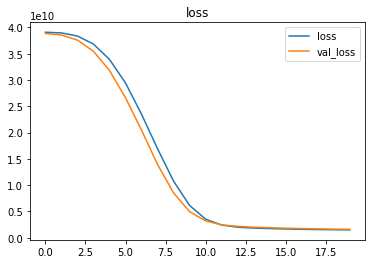

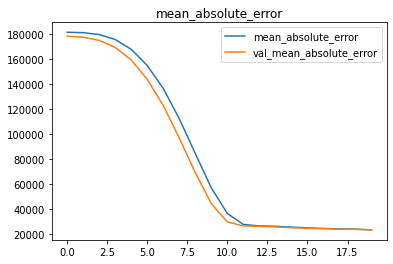

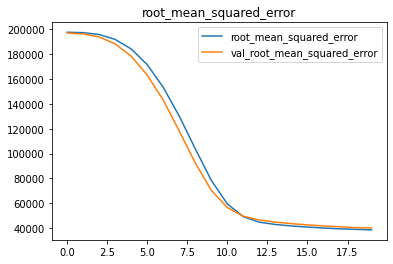

In [189]:
# Evaluate the model
plot_history(history1)

### Second Model

In [190]:
# We will only make slight modifications to the first model for our second
# neural network. We will see how changing the actiavtion functions affects
# the model

# Instantiate a model
model2 = Sequential()

In [191]:
# Add layers to the model
model2.add(Dense(266, input_dim = input_dim, activation = 'linear'))
model2.add(Dense(133, activation = 'linear'))
model2.add(Dense(1, activation = 'linear'))
model2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 266)               69426     
                                                                 
 dense_76 (Dense)            (None, 133)               35511     
                                                                 
 dense_77 (Dense)            (None, 1)                 134       
                                                                 
Total params: 105,071
Trainable params: 105,071
Non-trainable params: 0
_________________________________________________________________


In [192]:
# Compile the model
model2.compile(loss = 'mse', 
               optimizer = 'adam',
               metrics = [metrics.MeanAbsoluteError(),
                          metrics.RootMeanSquaredError()])

In [193]:
# Train the model
history2 = model2.fit(X_train_proc, y_train,
                      validation_data = (X_test_proc, y_test),
                      epochs = 20,
                      verbose = 0)

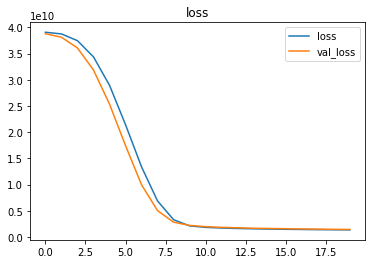

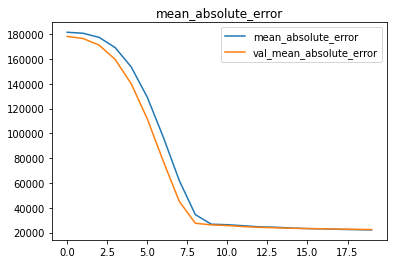

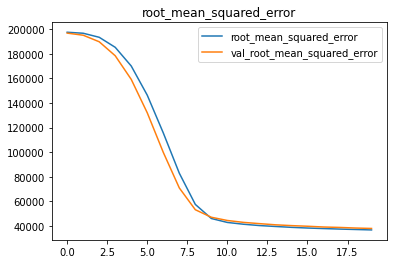

In [194]:
# Plot the history
plot_history(history2)

> Changing the activation function gave us a neglible improvment. We will add dropout to the next model in the hope of reducing the training time.

### Third Model

In [195]:
# Our third model will use a linear activation function and add dropout in an 
# attempt to reduce training time.

# Instantiate a model
model3 = Sequential()

In [196]:
# Add layers to the model
model3.add(Dense(266, input_dim = input_dim, activation = 'linear'))
model3.add(Dropout(0.3))
model3.add(Dense(133, activation = 'linear'))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation = 'linear'))
model3.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 266)               69426     
                                                                 
 dropout_8 (Dropout)         (None, 266)               0         
                                                                 
 dense_79 (Dense)            (None, 133)               35511     
                                                                 
 dropout_9 (Dropout)         (None, 133)               0         
                                                                 
 dense_80 (Dense)            (None, 1)                 134       
                                                                 
Total params: 105,071
Trainable params: 105,071
Non-trainable params: 0
_________________________________________________________________


In [197]:
# Compile the model
model3.compile(loss = 'mse', 
               optimizer = 'adam',
               metrics = [metrics.MeanAbsoluteError(),
                          metrics.MeanSquaredError()])

In [198]:
# Train the model
history3 = model3.fit(X_train_proc, y_train,
                      validation_data = (X_test_proc, y_test),
                      epochs = 20,
                      verbose = 0)

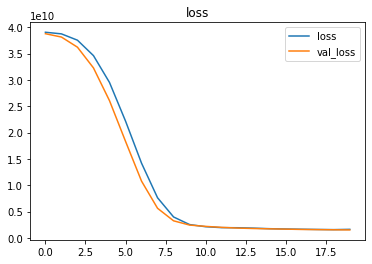

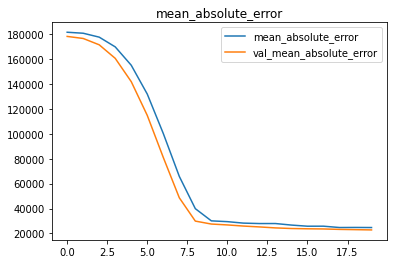

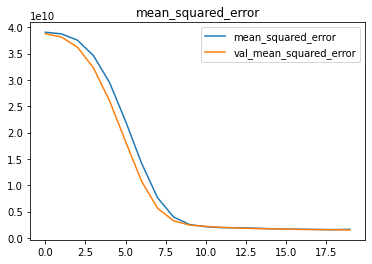

In [199]:
# Plot the history
plot_history(history3)

> Regularizing our model with dropout did not appear to improve our model, nor did it reduce training time. Our next model will add a hidden layer and more nodes.

### Fourth Model

In [200]:
# We will increase the number of nodes in this model and add an additional 
# hidden layer to the model

# Instantiate the model
model4 = Sequential()

In [201]:
# Add layers to the model
model4.add(Dense(500, input_dim = input_dim, activation = 'linear'))
model4.add(Dense(500, activation = 'linear'))
model4.add(Dense(250, activation = 'linear'))
model4.add(Dense(1, activation = 'linear'))
model4.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 500)               130500    
                                                                 
 dense_82 (Dense)            (None, 500)               250500    
                                                                 
 dense_83 (Dense)            (None, 250)               125250    
                                                                 
 dense_84 (Dense)            (None, 1)                 251       
                                                                 
Total params: 506,501
Trainable params: 506,501
Non-trainable params: 0
_________________________________________________________________


In [202]:
# Compile the model
model4.compile(loss = 'mse', 
               optimizer = 'adam',
               metrics = [metrics.MeanAbsoluteError(),
                          metrics.RootMeanSquaredError()])

In [203]:
# Train the model
history4 = model4.fit(X_train_proc, y_train,
                      validation_data = (X_test_proc, y_test),
                      epochs = 20,
                      verbose = 0)

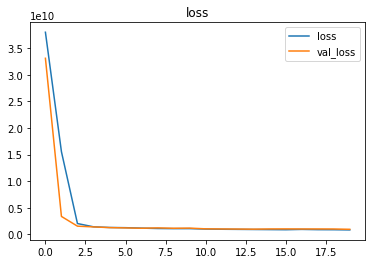

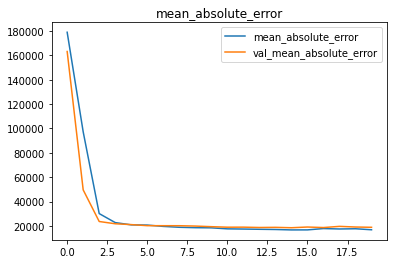

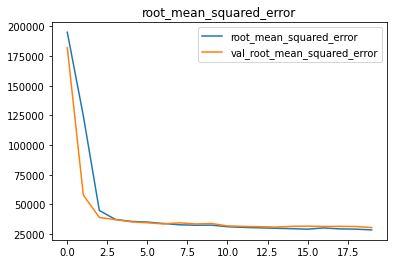

In [204]:
# Plot the history
plot_history(history4)

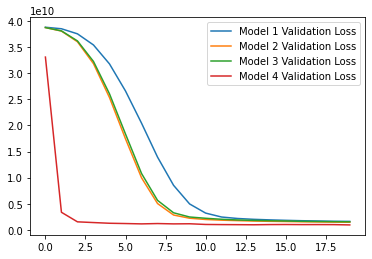

In [205]:
# Compare the loss for the test data for each model
plt.plot(history1.history['val_loss'], label = 'Model 1 Validation Loss')
plt.plot(history2.history['val_loss'], label = 'Model 2 Validation Loss')
plt.plot(history3.history['val_loss'], label = 'Model 3 Validation Loss')
plt.plot(history4.history['val_loss'], label = 'Model 4 Validation Loss')
plt.legend()

> We see from the above that each successive model gives slight improvements to the mean squared error. The extra hidden layer and increased nodes gave us a model that needed fewer epochs.

### Fifth Model

In [206]:
# We will try an additional hidden layer for this model

# Instantiate the model
model5 = Sequential()

In [207]:
# Add layers to the model
model5.add(Dense(500, input_dim = input_dim, activation = 'linear'))
model5.add(Dense(500, activation = 'linear'))
model5.add(Dense(250, activation = 'linear'))
model5.add(Dense(250, activation = 'linear'))
model5.add(Dense(1, activation = 'linear'))
model5.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 500)               130500    
                                                                 
 dense_86 (Dense)            (None, 500)               250500    
                                                                 
 dense_87 (Dense)            (None, 250)               125250    
                                                                 
 dense_88 (Dense)            (None, 250)               62750     
                                                                 
 dense_89 (Dense)            (None, 1)                 251       
                                                                 
Total params: 569,251
Trainable params: 569,251
Non-trainable params: 0
_________________________________________________________________


In [208]:
# Compile the model
model5.compile(loss = 'mse', 
               optimizer = 'adam',
               metrics = [metrics.MeanAbsoluteError(),
                          metrics.MeanSquaredError()])

In [209]:
# Train the model
history5 = model5.fit(X_train_proc, y_train,
                      validation_data = (X_test_proc, y_test),
                      epochs = 20,
                      verbose = 0)

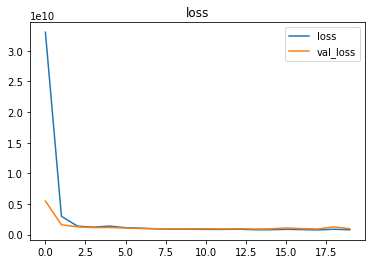

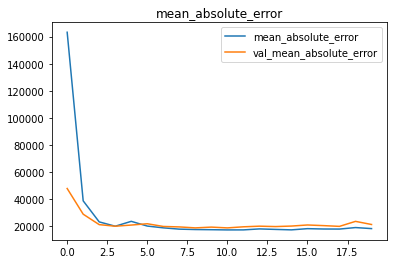

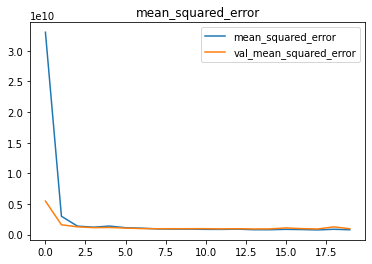

In [210]:
# Plot the history
plot_history(history5)

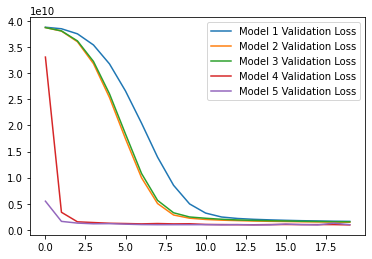

In [211]:
# Compare the loss for the test data for each model
plt.plot(history1.history['val_loss'], label = 'Model 1 Validation Loss')
plt.plot(history2.history['val_loss'], label = 'Model 2 Validation Loss')
plt.plot(history3.history['val_loss'], label = 'Model 3 Validation Loss')
plt.plot(history4.history['val_loss'], label = 'Model 4 Validation Loss')
plt.plot(history5.history['val_loss'], label = 'Model 5 Validation Loss')
plt.legend()

## Final Model

In [227]:
# We choose our fifth model to be our final model
final_model = model5

In [228]:
# Evaluate the final model
train_preds = final_model.predict(X_train_proc)
test_preds = final_model.predict(X_test_proc)

# Metrics for the training data
train_mae = mean_absolute_error(train_preds, y_train)
train_mse = mean_squared_error(train_preds, y_train)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(train_preds, y_train)

# Metrcis for the test data
test_mae = mean_absolute_error(test_preds, y_test)
test_mse = mean_squared_error(test_preds, y_test)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_preds, y_test)

# Display the data
model_metrics = pd.DataFrame({'MAE': [train_mae, test_mae],
                              'MSE': [train_mse, test_mse],
                              'RMSE': [train_rmse, test_rmse],
                              'R2': [train_r2, test_r2]},
                             index = ['Train', 'Test'])
model_metrics.round(4)

,MAE,MSE,RMSE,R2
Train,19039.5728,7.954954e+08,28204.5283,0.8601
Test,21058.7945,9.693978e+08,31135.1545,0.8412


> Our metrics tell us our model is able to explain about 85% of the variance in our data. A typical prediction is off by about \$19,000. Our root mean squared error of about \$30,000 tells us our model is making some larger errors.

In [214]:
# Load the test.csv file so we can make predictions for the Kaggle competition.
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRNru042_rhJ7yt3PPH3kJ_Y7Qg6RbGgABLNKowxojEuzxuLf7lyciKmz-M5q0ObJW3KJnDOLrYoKAD/pub?output=csv'
pred_df = pd.read_csv(url, index_col = 'Id')
pred_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [215]:
# Process the pred_df for use with the model
X_pred_df_proc = col_transformer.transform(pred_df)

In [216]:
# Construct the csv for the Kaggle submission
y_df = pd.DataFrame(final_model.predict(X_pred_df_proc), 
                    index = pred_df.index,
                    columns = ['SalePrice'])
#y_df['SalePrice'] = list(final_model.predict(X_pred_df_proc))
y_df

,SalePrice
Id,
1461,121743.875000
1462,145117.734375
1463,180244.875000
1464,198676.984375
1465,235353.078125
...,...
2915,72509.625000
2916,73370.164062
2917,178356.406250


In [217]:
# Make the csv file
y_df.to_csv('submission.csv')

> Screenshot of Kaggle Submission
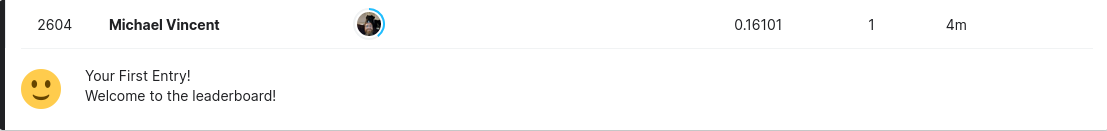

![](https://github.com/mvince33/Coding-Dojo/blob/main/week11/path?raw=1)